# Part 1: Fundamentals

## Concepts [10 minutes]

### Level 2 Swath vs. Level 3 Datacube

https://www.earthdata.nasa.gov/learn/earth-observation-data-basics/data-processing-levels

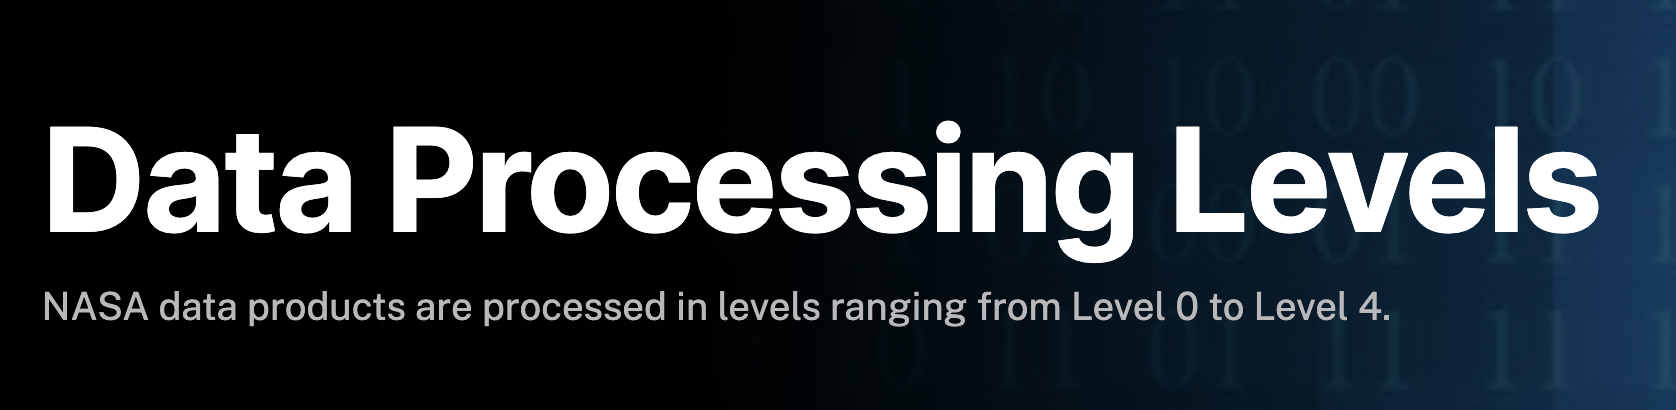

- **L2:** 
  - **What it is:** Geophysical variables (like temperature, chlorophyll, etc.) derived from raw satellite measurements (Level 1) but still tied to the original sensor's observation geometry—typically on a swath or orbital path.
  - **Spatial characteristics:** Irregularly spaced; not gridded. Each data point corresponds to a specific location and time when the satellite passed overhead.
  - **Use case:** Good for high-resolution analysis, precise sensor-based studies, and custom reprocessing or regional studies.
  - **Example:** Sea surface temperature values directly from satellite passes with coordinates and timestamps per pixel.

- **L3:**
  - **What it is:** L2 data that has been mapped onto a uniform spatial and/or temporal grid. This often involves averaging, interpolation, or compositing over a period (daily, weekly, monthly) or area.
  - **Spatial characteristics:** Gridded, usually regular latitude-longitude or projected grid.
  - **Use case:** Easier for large-scale analysis, modeling, and visualization. More manageable for data assimilation or comparisons.
  - **Example:** Daily global chlorophyll concentration mapped to a 0.25° x 0.25° lat/lon grid.


| Feature           | Level 2                          | Level 3                            |
|------------------|----------------------------------|------------------------------------|
| Processing Level | Derived but ungridded            | Gridded and often aggregated       |
| Format           | Swath/orbit-based, irregular     | Regular grid (e.g., lat/lon)       |
| Use Case         | Sensor-based, fine-scale work    | Large-scale trends, models         |

### GDAL Raster Storage Model

- **Raster Grid**: GeoTIFF stores raster data in grid form, where each cell corresponds to a geographic location.
- **Geo-referencing**: Supports geo-referencing with coordinate reference systems (CRS), enabling spatial mapping.
- **Compression**: Various compression formats (e.g., LZW, DEFLATE) are supported to reduce storage size.
- **Multi-band Support**: Can store multiple bands in a single file, useful for multi-layered raster datasets.
- **TIFF Standard**: GeoTIFF is based on the TIFF (Tagged Image File Format) standard, allowing for compatibility with many image processing tools.
- **Extensive Metadata**: Stores metadata, including projection information and auxiliary data like creation date, resolution, etc.

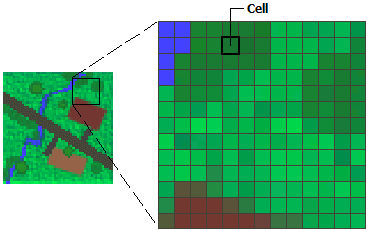

Source: https://desktop.arcgis.com/en/arcmap/latest/manage-data/raster-and-images/what-is-raster-data.htm

**What makes a GeoTIFF a COG?**

A **Cloud-Optimized GeoTIFF (COG)** is a specific subset of GeoTIFF designed for efficient streaming and access over the web/cloud. It requires internal tiling, properly ordered overviews, metadata at the beginning of the file for fast HTTP range requests.

Check out Tom Nicholas' blog post [Fundamentals: What is Cloud-Optimized Scientific Data?](https://earthmover.io/blog/fundamentals-what-is-cloud-optimized-scientific-data) to learn more about what makes data "cloud-optimized".

### Zarr: cloud-optimized nD array storage

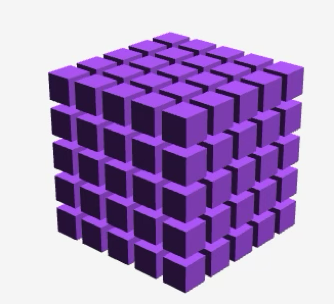

- **Chunked Data**: Zarr uses a chunked storage format, splitting arrays into smaller, manageable chunks.
- **Compression**: Zarr supports compression of individual chunks, allowing for efficient storage.
- **Flexible Backends**: Zarr can store data on various backends, such as local file systems, cloud storage (e.g., S3), or distributed file systems (e.g., Hadoop HDFS).
- **Hierarchical**: Zarr supports hierarchical structures, allowing for the organization of multiple arrays in a directory-like structure.
- **Parallelism**: Supports parallel reading/writing, making it suitable for large-scale computations.
- **Self-describing**: Arbitrary metadata is allowed and is embedded within the storage format, providing self-describing arrays.

For more, see the [Zarr website](https://zarr.readthedocs.io/en/stable/)


## GLAD LULC Data: A L3 Dataset [10 minutes]

In this tutorial, we will be working with the Global Land Analysis & Discovery (GLAD) Global Land Cover and Land Use Change, 2000-2020 dataset: https://glad.umd.edu/dataset/GLCLUC2020. The data is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

> Potapov, P., Hansen, M.C., Pickens, A., Hernandez-Serna, A., Tyukavina, A., Turubanova, S., Zalles, V., Li, X., Khan, A., Stolle, F. and Harris, N., 2022. The global 2000-2020 land cover and land use change dataset derived from the Landsat archive: first results. Front. Remote Sens. 3: 856903. doi: 10.3389/frsen. https://doi.org/10.3389/frsen.2022.856903

This 30m dataset consists of 10° x 10° tiles degree tiles of combined land cover for 2000, 2005, 2010, 2015 and 2020, as well as 2000-2020 land cover/use change. We will be using the annual land use and land cover data for this tutorial, but feel free to challenge yourself and ingest the land use change data on your own!

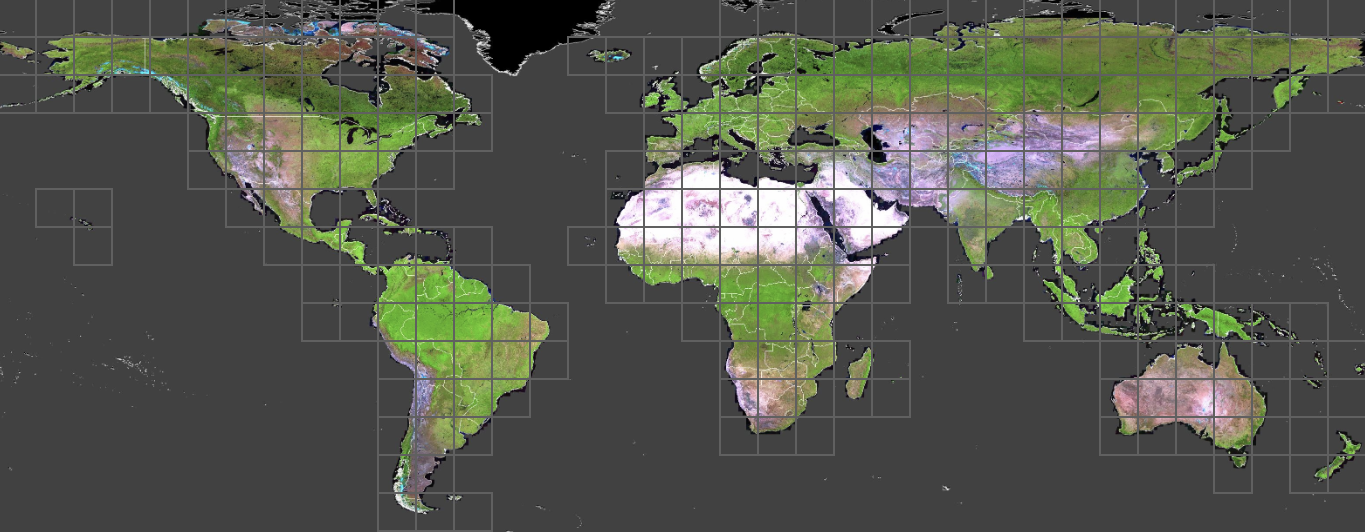

This dataset is formatted as individual 10° x 10° degree granules stored in `TIF` files, one per year. 

To get a better feel for this dataset, download a GeoTIFF from the [GLAD website](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/download.html) and visualize it in QGIS:
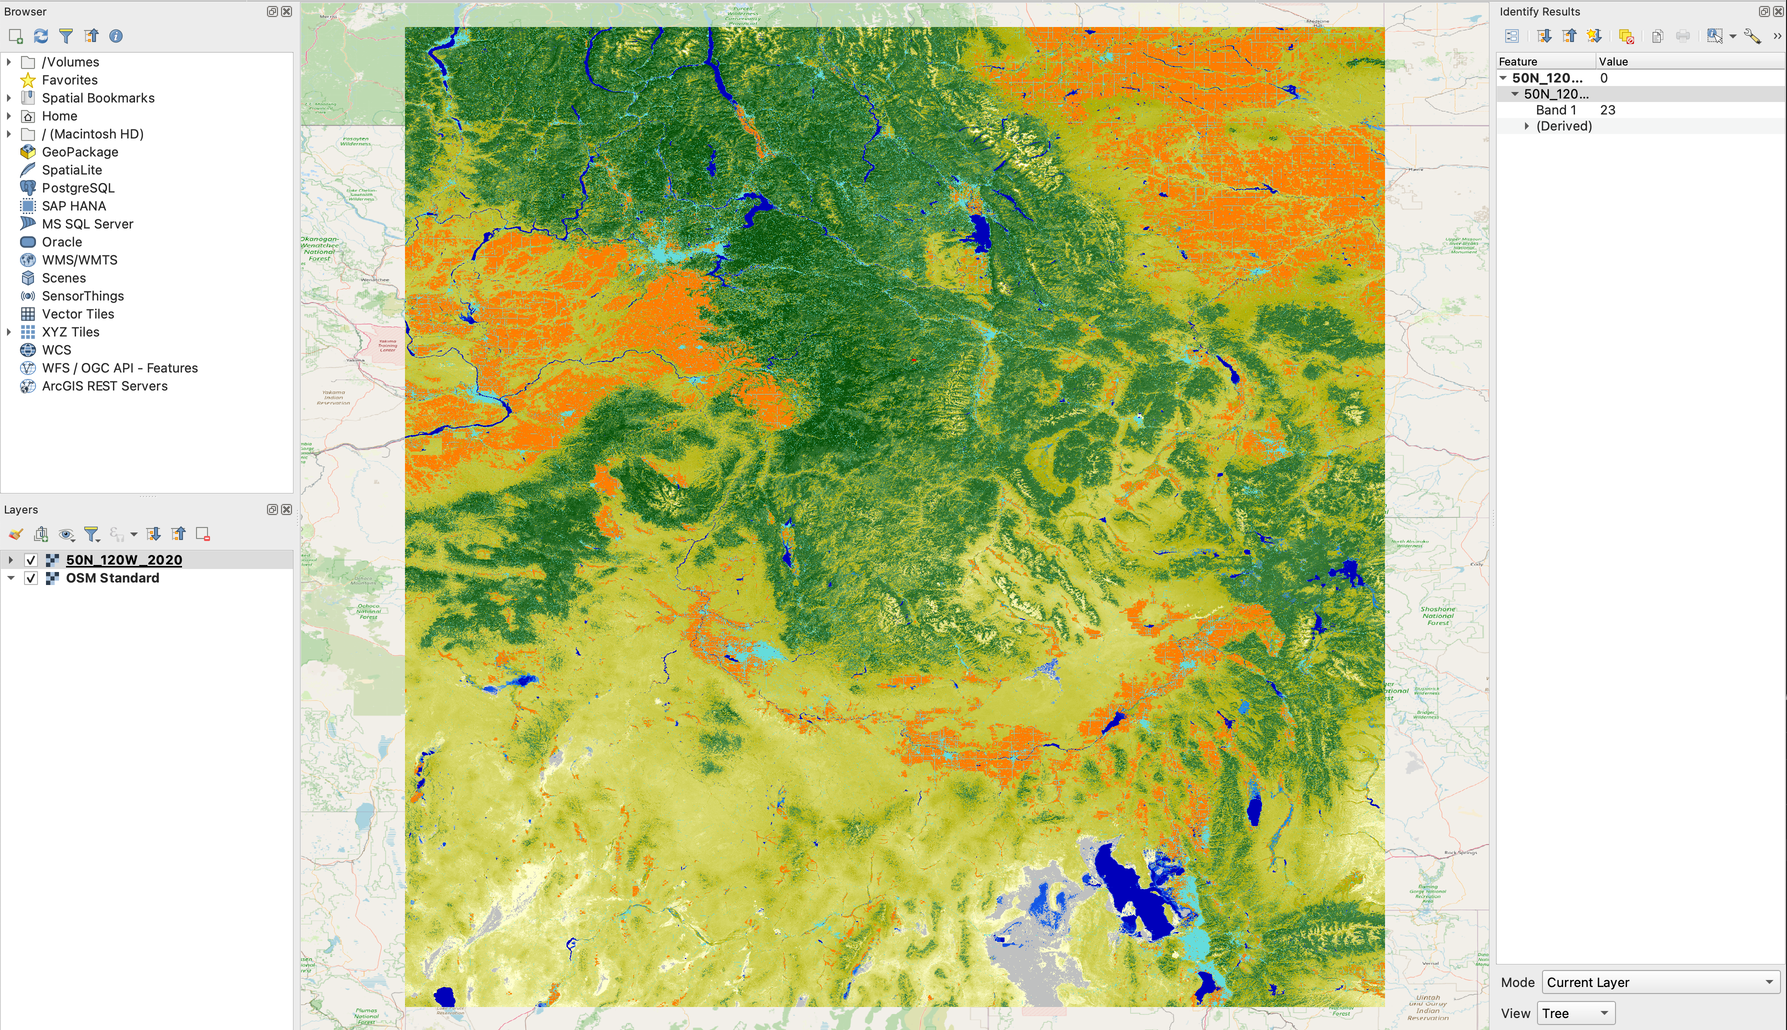


Each pixel corresponds to a value between 0-255 representing a land classification. But how do we know what each of these values represent? This is not stored in the dataset metadata. Instead, there is a separate [`legend` file](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/legend.xlsx) that explains these classifications. Here is a general summary for simplicity:

| Map Value Range | General Class           |
|-----------------|--------------------------|
| 0–1             | True desert              |
| 2–18            | Semi-arid                |
| 19–24           | Dense short vegetation   |
| 25–48           | Tree cover (Terra Firma) |
| 100–101         | Salt pan                 |
| 102–118         | Sparse vegetation        |
| 119–124         | Dense short vegetation   |
| 125–148         | Tree cover (Wetland)     |
| 200–207         | Open surface water       |
| 241             | Snow/ice                 |
| 244             | Cropland                 |
| 250             | Built-up                 |
| 254             | Ocean                    |
| 255             | No data                  |

All other values between 0-255 not in this chart are unused.

We will start by converting a subset of one of these tiles for one year of data into Zarr and visualizing the result. We will then set up a workflow to convert the same tile over all available years into a Zarr datacube using Icechunk. We will build up to creating a global Zarr datacube for all years of GLAD data and will use this global cube for downstream AOI-specific analysis.

#  Getting Started: The Process of Building a Zarr Datacube [1 hour]

## Exercise 1: GeoTIFF to Zarr with a single tile [25 minutes]

In this exercise, we will load in a single GeoTIFF into xarray using [rioxarray](https://corteva.github.io/rioxarray/html/modules.html) and show how to navigate the Xarray repr. We will then do some quick visualizations of the tile and save out the Xarray dataset to Zarr. 

To start, let's read in a single GLAD LULC tile from the year 2000 from Google Cloud Storage. The data can also be downloaded to local files [here](https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/download.html). We will use rioxarray's [`open_rasterio`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray-open-rasterio) for this operation:

In [1]:
import rioxarray

year = 2000  # Feel free to change this to 2005, 2010, 2015, or 2020
file_name = (
    "50N_120W"  # Feel free to change this to any of the other files in the dataset
)

url = f"https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/{year}/{file_name}.tif"

da = rioxarray.open_rasterio(url, masked=True)
da

<xarray.DataArray (band: 1, y: 40000, x: 40000)> Size: 6GB
[1600000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 320kB -120.0 -120.0 -120.0 ... -110.0 -110.0 -110.0
  * y            (y) float64 320kB 50.0 50.0 50.0 50.0 ... 40.0 40.0 40.0 40.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Now, let's examine the data structure. This at first appears to be a 3-dimensional tile of size `(band: 1, y: 40000, x: 40000)`, where each value of `x` and `y` represent a 30m pixel, giving us `1 x 40,000 x 40,000 = 1.6 billion` 30m x 30m pixels in this dataset. 

#### Xarray: Analyze nD array datasets with the help of metadata

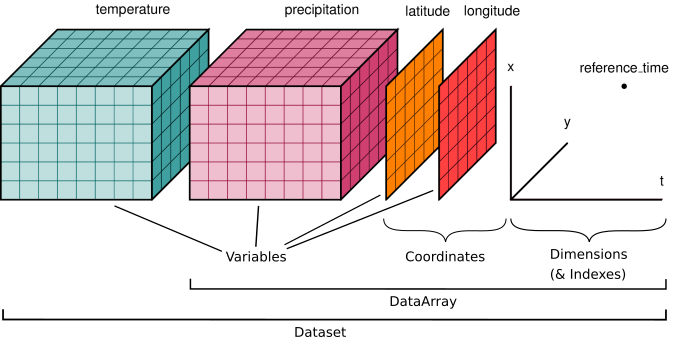

- **N-dimensional Arrays**: Xarray builds on the NumPy model, but adds labeled dimensions (e.g., time, latitude, longitude) for easier data manipulation.
- **Labeled Axes**: Xarray understands that axes tend to be associated with coordinate values (e.g. axis ticks on a plot), and allows you to use those coordinate values for analysis.
- **Metadata**: Xarray allows for rich metadata to be stored alongside data, making it more self-describing.
- **Integration with Dask**: Xarray supports integration with Dask for handling larger-than-memory datasets and parallel computations.
- **Flexible I/O**: Supports reading and writing data from various formats like NetCDF, Zarr, and more.

To learn more about Xarray, see the [Xarray tutorial](https://tutorial.xarray.dev/intro.html)

We see Xarray's support for metadata in the dataset above
1. The dimensions are named: `band`, `x`, and `y`
2. There are coordinate labels associated with these dimensions: `x` is in [-120, -110], and `y` is in [50, 40]
3. The `spatial_ref` auxiliary coordinate variable contains CRS information. This is usually called a "grid mapping" variable.


#### Back to the dataset
The `band` dimension here is a bit misleading; since the value is 1, it does not really add a third dimension to this dataset; we will drop it here shortly.

We can see that we have this `spatial_ref` coordinate, which is a special zero-dimensional coordinate variable variable added by `rioxarray` to preserve the coordinate reference system (CRS) information. 

It usually has no valid value. The attributes attached are important, they record:
- `crs_wkt` – the full WKT string of the CRS
- `grid_mapping_name` – a standard CF-compliant mapping name (e.g., transverse_mercator, latitude_longitude)
Other projection-specific attributes (e.g., `false_easting`, `longitude_of_central_meridian`, etc.)

For more see the [CF conventions](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.11/cf-conventions.html#grid-mappings-and-projections)

In [2]:
da.coords["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 8B
array(0)
Coordinates:
    spatial_ref  int64 8B 0
Attributes:
    crs_wkt:                      GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    semi_major_axis:              6378137.0
    semi_minor_axis:              6356752.314245179
    inverse_flattening:           298.257223563
    reference_ellipsoid_name:     WGS 84
    longitude_of_prime_meridian:  0.0
    prime_meridian_name:          Greenwich
    geographic_crs_name:          WGS 84
    horizontal_datum_name:        World Geodetic System 1984
    grid_mapping_name:            latitude_longitude
    spatial_ref:                  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["...
    GeoTransform:                 -120.0 0.00025 0.0 50.0 0.0 -0.00025

It's important to note here that we did not actually read in all of the tile data; we actually only read in the metadata, which is why these operations were so quick! We will actually have to load the data in for operations that require direct data access like plotting and writing to Zarr. These will require some additional optimizations for these large tiles. 

### Subsetting

For this first part of the tutorial, we will subset this tile to expedite the first few exercises. We will discuss optimizations when we get to building the global Zarr dataset. 

In [3]:
# Select a subset of the data
x_slice = slice(-112.5, -111.5)  # None for whole tile
y_slice = slice(41, 40.5)  # None for whole tile
da_sample = da.sel(x=x_slice, y=y_slice)
da_sample

<xarray.DataArray (band: 1, y: 2000, x: 4000)> Size: 32MB
[8000000 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

You will find that for a lot of Level 3 geospatial datasets, the data is stored in a single band (often named "band" -- very original!) as it is here. Let's rename this band variable to "lulc" just to be a bit more explicit. 

In [4]:
da_sample.name = "lulc"

We will also remove the `band` dim. Since it only has one value, it doesn't hold additional information along that axis, so removing it will simplify the array shape from a 3D array to a 2D array.

In [5]:
da_sample = da_sample.squeeze("band", drop=True)
da_sample

<xarray.DataArray 'lulc' (y: 2000, x: 4000)> Size: 32MB
[8000000 values with dtype=float32]
Coordinates:
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Plotting

Visualization is essential for geospatial data. How can we know that our data was correctly loaded into xarray without actually looking at it? Below are a few different approaches to plotting xarray data in a notebook. 

**Cloud vs. Local Latencies**

Note that the data must be loaded in before it can be plotted. Loading data from the cloud has higher latency, and thus loading data in from a cloud source vs. from your local machine can cause a large disparity in runtime.

**Visualizing in QGIS**

QGIS natively supports TIFF and GeoTIFFS; however, support for Zarr visualization in QGIS is still ongoing. For now, we will plot the data in this notebook.

In [6]:
# Load the data into memory from the cloud
# This may take awhile depending on your internet connection, the size of the file, and whether it is local or in cloud storage
# This is also slow because we are loading non-cloud optimized data
da_sample = da_sample.load()
da_sample

<xarray.DataArray 'lulc' (y: 2000, x: 4000)> Size: 32MB
array([[207., 207., 207., ...,  22.,  29.,  29.],
       [207., 207., 207., ...,  22.,  28.,  30.],
       [207., 207., 207., ...,  28.,  29.,  28.],
       ...,
       [ 14.,  14.,  14., ...,  21.,  21.,  22.],
       [ 14.,  14.,  14., ...,  21.,  22.,  22.],
       [ 14.,  14.,  14., ...,  21.,  22.,  22.]],
      shape=(2000, 4000), dtype=float32)
Coordinates:
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

#### Leafmap

[leafmap](https://leafmap.org/) is good for plotting xarray data because it combines the mapping power of Leaflet (via `ipyleaflet` or `folium`) with convenient tools for handling raster and vector geospatial data, including xarray. It can automatically convert xarray DataArrays into interactive map layers, supporting time sliders, colorbars, and basemaps — making it especially useful for visualizing geospatial timeseries or remote sensing data with minimal setup.

In [7]:
import leafmap


def plot_leafmap(data_to_plot):
    m = leafmap.Map(center=(40, -100), zoom=11)
    m.add_raster(
        data_to_plot, nodata=255, opacity=0.6, colormap="viridis", layer_name="LULC"
    )
    m.add("inspector")
    return m

In [8]:
# NOTE: Tile data may not plot in Leafmap in a coiled notebook
plot_leafmap(da_sample)

Map(center=[40.75, -112.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

#### hvPlot

[hvPlot](https://hvplot.holoviz.org/) is great for large xarray datasets because it integrates well with xarray, supports Dask for lazy evaluation, and leverages Datashader to efficiently render millions of points without performance loss. It also enables interactive, zoomable plots with minimal code, making it ideal for exploring complex geospatial or time-series data.

In [9]:
import holoviews as hv
import hvplot.pandas  # needed for tile sources
import hvplot.xarray  # needed for hvplot
from holoviews.element.tiles import EsriImagery  # or other tile source

hv.extension("bokeh")


def plot_hvplot(data_to_plot):
    # rasterize=True will enable datashading for large datasets and will downsample the data based on the aggregation method
    img = data_to_plot.hvplot.image(
        x="x",
        y="y",
        cmap="viridis",
        aggregator="first",
        rasterize=True,
        frame_width=500,
        dynamic=True,
        geo=True,
    )
    return EsriImagery() * img

In [10]:
plot_hvplot(da_sample)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e8aaf252-8f33-4146-b33f-d8b883c8afe0': {'version…

### Writing Data to Zarr

Before we move on from this single data tile, let's write our subset of data to Zarr using xarray's [`to_zarr`](https://docs.xarray.dev/en/latest/generated/xarray.Dataset.to_zarr.html) method.

- `store`: is the *backend storage interface* — it defines *where and how* the data is physically stored.
  - Think of a store as:
    - A directory on disk (e.g., via `zarr.storage.LocalStore`)
    - A cloud bucket (e.g., `s3://bucket/path` via `zarr.storage.FsspecStore` with `fsspec`)
    - An in-memory dictionary (via `zarr.storage.MemoryStore`)
  - Icechunk, which we'll cover in detail below, is also a Zarr Store 
- `group`: is a *logical container* — it organizes arrays and other groups in a hierarchical structure, kind of like directories in a filesystem
  - A Zarr Group:
    - Can contain multiple Zarr arrays
    - Can contain nested groups
    - Lives within a store
    - Has its own metadata (e.g., attributes stored in `zarr.json`)


In [11]:
# NOTE: This requires access to the "em-cng-workshop" S3 bucket in Earthmover's AWS account
# Replace the bucket name with your own if you have access to a different S3 bucket
random_id = "workshop-test"  # TODO: generate a random id! You can use your name or anything else that tickles your fancy
bucket_name = "em-cng-workshop"
store = f"s3://{bucket_name}"
group = random_id
da_sample.to_zarr(store=store, group=group)

Let's look at what was written out:

In [12]:
import boto3

s3 = boto3.client('s3')
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=random_id)

# Check and print the object keys
if 'Contents' in response:
    for obj in response['Contents']:
        print(obj['Key'])
else:
    print("No objects found.")

workshop-test/lulc/c/0/0
workshop-test/lulc/c/0/1
workshop-test/lulc/c/0/2
workshop-test/lulc/c/0/3
workshop-test/lulc/c/1/0
workshop-test/lulc/c/1/1
workshop-test/lulc/c/1/2
workshop-test/lulc/c/1/3
workshop-test/lulc/c/2/0
workshop-test/lulc/c/2/1
workshop-test/lulc/c/2/2
workshop-test/lulc/c/2/3
workshop-test/lulc/c/3/0
workshop-test/lulc/c/3/1
workshop-test/lulc/c/3/2
workshop-test/lulc/c/3/3
workshop-test/lulc/zarr.json
workshop-test/spatial_ref/zarr.json
workshop-test/x/c/0
workshop-test/x/zarr.json
workshop-test/y/c/0
workshop-test/y/zarr.json
workshop-test/zarr.json


Let's quickly discuss the storage representation (which is the Zarr v3 representation). You can find more details in the [Zarr docs](https://zarr-specs.readthedocs.io/en/latest/v3/core/index.html#stored-representation). 

* `zarr.json` - Root metadata for the whole store (version, format)
* `<group_path>/zarr.json` - Group metadata
* `<array_path>/zarr.json` - Array metadata
* Chunk files
    * stored under the `c/` subdirectory within each array node (e.g. `<array_path>/c/...`)
    * chunk filename is based on chunk indices separated by slashes (`/`)

We can also easily read this dataset back into Xarray with [`open_zarr`](https://docs.xarray.dev/en/stable/generated/xarray.open_zarr.html)

In [13]:
import xarray as xr

ds = xr.open_zarr(store=store, group=group)
ds

<xarray.Dataset> Size: 64MB
Dimensions:      (x: 4000, y: 2000)
Coordinates:
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
Data variables:
    spatial_ref  int64 8B ...
    lulc         (y, x) float64 64MB dask.array<chunksize=(500, 1000), meta=np.ndarray>

## Exercise 2: Creating a Zarr Datacube From a Timeseries [10 minutes]

We will now create a timeseries datacube over a single tile. To do this, we will read each tile into an xarray dataset, add a `year` dimension to the tile, and then "stack" them together along the `year` dimension. This will yield a 3 dimensional cube `(year, x, y)` of LULC data.

We will first use a naive approach to illustrate this general flow with a very small sample of data. We will then work up to using more advanced approaches like Icechunk for version control and virtualization to prevent data duplication.

But, let's start with a straightforward example. We will employ Xarray's [`concat`](https://docs.xarray.dev/en/stable/generated/xarray.concat.html) method which concatenates multiple data arrays along a specified dimension. Here we add a new dimension called "year" with a single value of either 2000, 2005, 2010, 2015, or 2020. We will then concatenate the data arrays along the "year" dimension to create a "stack" of data. This method is useful for creating a time series dataset from multiple time steps.

In [14]:
import rioxarray
import xarray as xr

file_name = (
    "50N_120W"  # Feel free to change this to any of the other files in the dataset
)
years = [2000, 2005, 2010, 2015, 2020]
x_slice = slice(-112.5, -111.5)
y_slice = slice(41, 40.5)
data_arrays = []

for year in years:
    url = f"https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/{year}/{file_name}.tif"
    da = rioxarray.open_rasterio(url)
    da = da.rename({"band": "lulc"})
    da = da.squeeze("lulc")
    # Subset the data to the area of interest
    da = da.sel(x=x_slice, y=y_slice)
    data_arrays.append(da)

# Concatenate the data arrays along the 'year' dimension
# NOTE: this call reads all the data into memory and may take a while for large datasets
combined = xr.concat(data_arrays, dim=xr.DataArray(years, dims="year"))
combined

<xarray.DataArray (year: 5, y: 2000, x: 4000)> Size: 40MB
array([[[207, 207, 207, ...,  22,  29,  29],
        [207, 207, 207, ...,  22,  28,  30],
        [207, 207, 207, ...,  28,  29,  28],
        ...,
        [ 14,  14,  14, ...,  21,  21,  22],
        [ 14,  14,  14, ...,  21,  22,  22],
        [ 14,  14,  14, ...,  21,  22,  22]],

       [[207, 207, 207, ...,  22,  27,  28],
        [207, 207, 207, ...,  22,  27,  28],
        [207, 207, 207, ...,  28,  27,  28],
        ...,
        [ 14,  14,  14, ...,  21,  21,  22],
        [ 14,  14,  14, ...,  21,  22,  22],
        [ 14,  14,  14, ...,  21,  22,  22]],

       [[207, 207, 207, ...,  22,  28,  28],
        [207, 207, 207, ...,  22,  28,  28],
        [207, 207, 207, ...,  29,  27,  27],
        ...,
        [ 14,  14,  14, ...,  21,  21,  22],
        [ 14,  14,  14, ...,  21,  22,  22],
        [ 14,  14,  14, ...,  21,  22,  22]],

       [[207, 207, 207, ...,  22,  28,  28],
        [207, 207, 207, ...,  22,  27,  28],
        [207, 207, 207, ...,  28,  28,  28],
        ...,
        [ 14,  14,  14, ...,  21,  21,  22],
        [ 14,  14,  14, ...,  21,  22,  22],
        [ 14,  14,  14, ...,  21,  22,  22]],

       [[207, 207, 207, ...,  22,  28,  28],
        [207, 207, 207, ...,  22,  28,  28],
        [207, 207, 207, ...,  28,  28,  28],
        ...,
        [ 14,  14,  14, ...,  21,  21,  22],
        [ 14,  14,  14, ...,  21,  22,  22],
        [ 14,  14,  14, ...,  21,  22,  22]]],
      shape=(5, 2000, 4000), dtype=uint8)
Coordinates:
    lulc         int64 8B 1
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B 0
  * year         (year) int64 40B 2000 2005 2010 2015 2020
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

We just read in 5x the amount of data into memory as we did in Exercise 1. The subset of data that we are using is pretty small, so the operation was relatively quick. If we wanted to use this naive approach with a larger AOI (say, the whole tile), we would want to consider chunking. 

In the [`rioxarray.open_rasterio()`]() call, we have the option of specifying `chunks`. Data chunking in Xarray (with Dask) is a way to break up large datasets into smaller, manageable pieces ("chunks") that can be processed lazily and in parallel. It’s essential when working with out-of-core data — data too big to fit into memory. 

This often leads to the age-old question: **How should I chunk my data?** See the Appendix for a walkthrough on how to calculate chunks based on the desired chunk size.

Let's discuss the data model here for a moment: we now have a 3D array of the shape `(year: 5, y: 2000, x: 4000)`. We have essentially stacked 5 years worth of 2-dimensional (x,y) array data into a datacube!

Now let's visualize our datacube!

In [15]:
# NOTE: Tile data may not plot in Leafmap in a coiled notebook
plot_leafmap(combined)

Map(center=[40.75, -112.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_…

In [16]:
plot_hvplot(combined)

BokehModel(combine_events=True, render_bundle={'docs_json': {'cd7be86b-9f6e-431a-8fe0-e4a13f5174c4': {'version…

Let's take this exercise a step further and explore how we can integrate Icechunk into this workflow for data versioning and management. 

## Exercise 3: Doing it all again with Icechunk 🧊 [20 minutes]

#### Icechunk: Transactions and Version Control for Zarr

[Icechunk](https://icechunk.io/en/latest/overview/) augments the Zarr storage model to provide additional features such as data version control and transactions. For production-grade datasets, it is an ideal complement to the Zarr storage model for geospatial data. Let's run through the same datacube exercise above, but with Icechunk!

- **Built on Zarr**: Icechunk is a backend for Zarr, inheriting all the benefits of Zarr’s chunked storage, compression, flexible backends, and hierarchical structure.
- **ACID Transactions**: Supports ACID (Atomicity, Consistency, Isolation, Durability) transactions, enabling safe concurrent access and modification of datasets while ensuring data reliability.
- **Versioning/Time travel**: Provides version control for scientific data, tracking changes at the chunk level, allowing users to revert to previous versions or compare different states of data.
- **Compatibility**: As a backend for Zarr, Icechunk integrates well with Python nD-array tooling.

For more, see the Icechunk [website](https://icechunk.io/en/latest/)

First, we will create a Icechunk repository from a Icechunk storage object, which points Icechunk to where it will read and write Zarr data.

In [17]:
import icechunk
import rioxarray
import xarray as xr

In [18]:
# Initialize Icechunk storage and repo
storage = icechunk.s3_storage(
    bucket=bucket_name,
    prefix=f"{random_id}/ic",
    from_env=True
)
ic_repo = icechunk.Repository.create(storage)

Since we will write to this icechunk repo, we will create a new writable session.

Importantly the changes in _this session_ are isolated from any other concurrent session (read or write).

In [19]:
session = ic_repo.writable_session(branch="main")

Now let's get some data and write it to the store:

In [20]:
x_slice = slice(-112.5, -111.5)
y_slice = slice(41, 40.5)


def get_lulc_data(year: str, file_name: str) -> xr.Dataset:
    url = f"https://storage.googleapis.com/earthenginepartners-hansen/GLCLU2000-2020/v2/{year}/{file_name}.tif"
    # Since we are not subsetting the tile, we will want to chunk the data into dask arrays
    # See Appendix: On Chunking for more information on chunk size selection
    da = rioxarray.open_rasterio(url, mask_and_scale=False)
    da = da.sel(x=x_slice, y=y_slice)
    da = da.squeeze("band", drop=True)
    da = da.expand_dims(year=[int(year)])
    da.name = "lulc"
    # Some file-specifinc information is stored in encoding. It is good practice to drop it
    # so that you can control exactly how the data are stored on disk.
    da = da.drop_encoding()
    # add a CF-compliant attribute to set spatial_ref as the grid_mapping variable
    da.attrs["grid_mapping"] = "spatial_ref"

    # These are useless, they promote from uint8 to float64
    del da.attrs["add_offset"]
    del da.attrs["scale_factor"]
    return da.to_dataset()

In [21]:
# Feel free to change this to any of the other files in the dataset
file_name = "50N_120W"
ds_2000 = get_lulc_data("2000", file_name)  # Get the tile for the year 2000
ds_2000

<xarray.Dataset> Size: 8MB
Dimensions:      (year: 1, x: 4000, y: 2000)
Coordinates:
  * year         (year) int64 8B 2000
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B 0
Data variables:
    lulc         (year, y, x) uint8 8MB 207 207 207 207 207 ... 22 22 21 22 22

Now that we have data for the year 2000, let's write that to our Icechunk store:

In [22]:
%%time

ds_2000.to_zarr(session.store, consolidated=False)

CPU times: user 109 ms, sys: 27.2 ms, total: 136 ms
Wall time: 771 ms


Depending on the size of the data, that step might have took a while because we had to write out the data from memory to disk, and to get it into memory xarray triggered loading it from remote storage.

In [23]:
session.commit("wrote data for the year 2000")

'5T38PM7W17EZT95QMBZ0'

Let's open and look at the Icechunk store we just created. Icechunk data is a Zarr store, so we can open it using Xarray's `open_zarr` function:

In [24]:
roundtrip = xr.open_zarr(session.store, consolidated=False)
roundtrip

<xarray.Dataset> Size: 8MB
Dimensions:      (year: 1, y: 2000, x: 4000)
Coordinates:
  * year         (year) int64 8B 2000
    spatial_ref  int64 8B ...
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
Data variables:
    lulc         (year, y, x) uint8 8MB dask.array<chunksize=(1, 500, 1000), meta=np.ndarray>

Now let's add the other years of data, committing each one separately to the Icechunk repo in each iteration of a loop:

In [25]:
for year in [2005, 2010, 2015]:
    # important, once you commit, a session becomes read-only
    # so we must create a new writable session in every loop
    session = ic_repo.writable_session("main")
    da_this_year = get_lulc_data(year, "50N_120W")
    roundtrip.to_zarr(
        session.store, append_dim="year", consolidated=False
    )  # Append to the existing dataset
    session.commit(f"wrote data for the year {year}")

In [26]:
ds = xr.open_zarr(session.store, consolidated=False, mask_and_scale=False)
ds

<xarray.Dataset> Size: 32MB
Dimensions:      (y: 2000, x: 4000, year: 4)
Coordinates:
  * y            (y) float64 16kB 41.0 41.0 41.0 41.0 ... 40.5 40.5 40.5 40.5
    spatial_ref  int64 8B ...
  * x            (x) float64 32kB -112.5 -112.5 -112.5 ... -111.5 -111.5 -111.5
  * year         (year) int64 32B 2000 2000 2000 2000
Data variables:
    lulc         (year, y, x) uint8 32MB dask.array<chunksize=(1, 500, 1000), meta=np.ndarray>

We have a datacube! It's Zarr, so this approach scales, but it's also Icechunk, so we have the version history of the data

In [27]:
list(ic_repo.ancestry(branch="main"))

[SnapshotInfo(id="JVJFJNCKPPJDS337BQZ0", parent_id=QSEM51EG7VCQH724CE6G, written_at=datetime.datetime(2025,5,6,20,45,14,829721, tzinfo=datetime.timezone.utc), message="wrote data..."),
 SnapshotInfo(id="QSEM51EG7VCQH724CE6G", parent_id=DXHHEBTW98QCPSJ3EA60, written_at=datetime.datetime(2025,5,6,20,45,10,819364, tzinfo=datetime.timezone.utc), message="wrote data..."),
 SnapshotInfo(id="DXHHEBTW98QCPSJ3EA60", parent_id=5T38PM7W17EZT95QMBZ0, written_at=datetime.datetime(2025,5,6,20,45,5,521253, tzinfo=datetime.timezone.utc), message="wrote data..."),
 SnapshotInfo(id="5T38PM7W17EZT95QMBZ0", parent_id=TTNCBEXV7WG9KPEH44HG, written_at=datetime.datetime(2025,5,6,20,45,1,300954, tzinfo=datetime.timezone.utc), message="wrote data..."),
 SnapshotInfo(id="TTNCBEXV7WG9KPEH44HG", parent_id=None, written_at=datetime.datetime(2025,5,6,20,44,57,202027, tzinfo=datetime.timezone.utc), message="Repository...")]

But wait! We forgot the final year of data (from 2020)!

With Zarr this could be a big problem - we would either have to rewrite the entire store (wasteful) or write only the new chunks and edit the metadata (unsafe if someone else is reading from it).

But with Icechunk this is both efficient and safe!




In [28]:
session = ic_repo.writable_session("main")
da_this_year = get_lulc_data("2020", "50N_120W")
da_this_year.to_zarr(session.store, append_dim="year", consolidated=False)
session.commit(f"wrote data for the year {year}")

'4KXKM5RERFH275CX2H5G'

## Exercise 4: On Your Own

Uh Oh! It seems like some of the data from 2020 is not correct. The below bounding box should be class 10. Try to update the dataset with this patch and commit it to Icechunk. 

In [29]:
## Write your code here
x_slice = slice(-112.5, -112.4)
y_slice = slice(41, 40.75)

## Virtualization [5 minutes]

This is cool, but we're duplicating the data in the TIFF files into a new location (in the chunks of the Zarr store). What if we didn't have to duplicate the data? This is the idea behind [VirtualiZarr](https://github.com/zarr-developers/VirtualiZarr)!

Icechunk stores references to chunks. Those chunks can live in the Icechunk store itself, or outside of it, as "virtual" chunks.


### Note: Supported file formats

Whilst VirtualiZarr's pluggable system of "virtual readers" in theory will allow it to "virtualize" a wide range of file formats, today it supports only a limited set of formats, including HDF5, netCDF4, netCDF3, and "native" Zarr v3. You can even [read pre-existing Kerchunk-formatted references](https://virtualizarr.readthedocs.io/en/stable/usage.html#opening-kerchunk-references-as-virtual-datasets), allowing you to convert those to Icechunk.

Work is ongoing to support both [(COGeo)TIFF](https://github.com/zarr-developers/VirtualiZarr/pull/524) (e.g. for this LULC dataset) and JPEG (e.g. [for Sentinel-2 data](https://discourse.pangeo.io/t/cloud-optimized-access-to-sentinel-2-jpeg2000/5072/5?u=tomnicholas)) in VirtualiZarr, and we plan to support lots more geospatial-related formats!

For now we will use a netCDF4 file to demonstrate how to use VirtualiZarr with Icechunk - the only difference is the keyword arguments you pass to `virtualizarr.open_virtual_dataset` in the first line of this coming section.


### Example: Virtualizing one netCDF file

Let's say we have a netCDF file on our local machine. 

In [30]:
import xarray as xr

# create an example pre-existing netCDF file
ds = xr.tutorial.open_dataset("air_temperature")
ds.to_netcdf("air.nc")

It takes up a few MB of storage space:

In [31]:
!du -ch air.nc

7.4M	air.nc
7.4M	total


We could resave this to Zarr / Icechunk like we did for the TIFF data above, but that would duplicate all the data on disk.

In [32]:
# open as a normal in-memory xarray dataset
ds = xr.open_dataset("air.nc")

# save all data again as a new zarr store
ds.to_zarr("air.zarr")

In [33]:
!du -ch -d 0 air.*

7.4M	air.nc
4.8M	air.zarr
 12M	total


We can see that the new Zarr store is comparable in size to the original netCDF file (though it seems Zarr's default compression has done significantly better than netCDF's!)

The same thing would be true if we use Xarray to write to Icechunk normally (i.e. without using VirtualiZarr):

In [34]:
import icechunk

storage = icechunk.local_filesystem_storage("./ic-non-virtual/")
repo = icechunk.Repository.create(storage)

In [35]:
session = repo.writable_session("main")

# save all data again into a new (non-virtual) Icechunk store
ds.to_zarr(session.store, consolidated=False)

session.commit("wrote non-virtual data")

'ACT21PEXQD1B85VC9QT0'

In [36]:
!du -ch -d 0 air.* ic*

7.4M	air.nc
4.8M	air.zarr
4.8M	ic-non-virtual
 17M	total


As expected, the Icechunk store with non-virtual chunks is (almost) exactly the same size as the conventional Zarr store.

But if instead we use `virtualizarr.open_virtual_dataset`, watch what happens...

In [38]:
import virtualizarr as vz

# extract the chunk references from the netCDF file as a "virtual" xarray Dataset
vds = vz.open_virtual_dataset("air.nc")

In [39]:
storage = icechunk.local_filesystem_storage("./ic-virtual/")
repo = icechunk.Repository.create(storage)

In [41]:
session = repo.writable_session("main")

# write the virtual references into Icechunk using this special accessor method
vds.virtualize.to_icechunk(session.store)

session.commit("wrote virtual data")

KeyError: '>i2'

In [ ]:
!du -ch -d 0 air.* ic*

7.4M	air.nc
4.8M	air.zarr
4.8M	ic-non-virtual
 44K	ic-virtual
 17M	total


The Icechunk store containing the virtual chunk references is over 1000x smaller! 

Nevertheless we can still read the data back from this Icechunk store in exactly the same way.

In [ ]:
roundtrip = xr.open_zarr(session.store, consolidated=False)
roundtrip

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB dask.array<chunksize=(2920, 25, 53), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

### What are "virtual chunk references"?

The way this works is that Icehunk is containing "virtual references" to the chunks inside the netCDF file, and reading the data back from the netCDF file when you read from the Icechunk store.

You can actually see the chunk references inside the virtual dataset object - they are stored in-memory in a `ChunkManifest` object:

In [ ]:
manifest = vds["air"].data.manifest
manifest

ChunkManifest<shape=(1, 1, 1)>

In [ ]:
manifest.dict()

{'0.0.0': {'path': 'file:///Users/tom/Documents/Work/Code/workshop-cng-2025-zarr/notebooks/air.nc',
  'offset': 15419,
  'length': 7738000}}

The chunk reference simply stores the location of the file containing the chunk, and the location of the chunk within the file. 

In this case the "air" variable contains a reference to only one chunk, but it could contain references to millions of chunks, split across any number of files or locations.

You can use VirtualiZarr to easily combine references to thousands of files using Xarray syntax, but that's a topic for another day!

## Breaktime!

That's it for Part 1 of this workshop. In Part 2, we will take a global GLAD LULC Zarr datacube and use it for some fun downstream analysis. 

If you have extra time, go back through this notebook and experiment a bit. Play with plotting, Icechunk, virtualization. Ask questions that are not explicitly covered here -- we are happy to chat all things Zarr, Xarray, Icechunk, and VirtualiZarr. 

See you after the break 👋